# 🚀 Otimização de Processos e Análise de Investimento em EPIs

### 📋 Contexto do Projeto
Este projeto nasceu de um desafio real de gestão: a necessidade de extrair indicadores estratégicos a partir de relatórios brutos de entrega de EPIs. O arquivo original, exportado do sistema, apresentava uma estrutura semi-estruturada (focada em impressão), o que impedia qualquer análise direta ou automação via ferramentas convencionais.

### 🛠️ O Problema de Dados
A planilha original era um "relatório visual" e não uma base de dados, contendo:
* Cabeçalhos repetidos e linhas de totais intercaladas.
* Nomes de funcionários e setores "escondidos" em células isoladas.
* Dados sensíveis expostos (necessitando de adequação à LGPD).

### 💡 A Solução (Engenharia e Visualização)
Desenvolvi um pipeline de tratamento de dados utilizando a **stack principal de Data Science**:

1.  **Pandas**: Utilizado para a manipulação de DataFrames, limpeza de dados e reestruturação do layout do relatório para o formato *Tidy Data* (tabular).
2.  **NumPy**: Aplicado para implementar a lógica de filtros condicionais e processamento matemático eficiente dos vetores de dados.
3.  **Matplotlib**: Utilizado para a criação de dashboards e visualizações gráficas que facilitam a identificação de tendências de consumo e picos de entrega.

### 📈 Entregas Realizadas
* **Anonimização de Dados**: Proteção da privacidade dos colaboradores via script.
* **Indicadores por Setor**: Identificação automática de áreas com maior demanda.
* **Controle de Gastos**: Visão financeira precisa por tipo de equipamento.
* **Automação**: O que levava horas de trabalho manual agora é processado em segundos.

---

In [6]:
!pip install odfpy

In [8]:
import numpy as np
import pandas as pd

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Projeto Final/PLANILHA_EPI_ANONIMIZADA.csv')

In [51]:
df.head()

,Cadastro,Nome,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Funcionario_Nome,Cargo
0,2024.0,Colaborador 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bombeiro:,Não,Cargo:,AJUDANTE GERAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AJUDANTE GERAL
2,EPI,Descrição,Medida,Motivo,Qtde,Entrega,Sequencia,Validade,Revisão,Instr.,Valor EPI,Tot.Vl,NaN,NaN,AJUDANTE GERAL
3,5400009.0,FILTRO MASCARA RC 1,NaN,7.0,TROCA/SUBSTITUIÇÃO,2.0,21/01/2026,1.0,17/11/2026,28/01/2026,Sim,17.49,34.98,NaN,AJUDANTE GERAL
4,540000.0,LUVA TÁTIL,NaN,7.0,TROCA/SUBSTITUIÇÃO,1.0,24/01/2026,1.0,NaN,NaN,Sim,2.59,2.59,NaN,AJUDANTE GERAL


In [ ]:

# Criar a coluna de Funcionário de forma inteligente:
# Só pega o nome se a coluna 'Cadastro' tiver o número do registro (ex: 2024)
# E se a linha debaixo indicar 'Cargo:' na Unnamed: 2
df['Funcionario_Nome'] = df['Nome'].where(pd.to_numeric(df['Cadastro'], errors='coerce').notna() & (df['Cadastro'].astype(str).str.len() <= 5))

# Criar a coluna de Cargo
df['Cargo'] = df['Unnamed: 3'].where(df['Unnamed: 2'] == 'Cargo:')

# Preencher para baixo (ffill) para que o nome e cargo acompanhem os EPIs
df['Funcionario_Nome'] = df['Funcionario_Nome'].ffill()
df['Cargo'] = df['Cargo'].ffill()

# Filtrar apenas as linhas que são EPIs de verdade
# (Onde a coluna Unnamed: 5 tem a quantidade, ex: 1, 2, 3...)
df_limpo = df[pd.to_numeric(df['Unnamed: 5'], errors='coerce').notna()].copy()

# Renomear e organizar
colunas_finais = {
    'Cadastro': 'ID_EPI',
    'Nome': 'Descricao_EPI',
    'Unnamed: 5': 'Quantidade',
    'Unnamed: 6': 'Data_Entrega',
    'Unnamed: 12': 'Valor_Total'
}
df_final = df_limpo.rename(columns=colunas_finais)

# Selecionar e mostrar
df_final = df_final[['Funcionario_Nome', 'Cargo', 'ID_EPI', 'Descricao_EPI', 'Quantidade', 'Data_Entrega', 'Valor_Total']]
df_final.head(10)

In [45]:
# Converte quantidades e valores para números
df_final['Quantidade'] = pd.to_numeric(df_final['Quantidade'], errors='coerce')
df_final['Valor_Total'] = pd.to_numeric(df_final['Valor_Total'], errors='coerce')

# Converte a data para o formato de data real do Python
df_final['Data_Entrega'] = pd.to_datetime(df_final['Data_Entrega'], dayfirst=True)

##Preparando para responder às perguntas

- Quantidade de EPI entregue por setor
- Quantidade de EPI entregue por funcionário
- Valor total gasto separado por EPI

In [ ]:
# Organizar os dados
dados_organizados = []
setor_atual = ""
funcionario_atual = ""

for i, linha in df_bruto.iterrows():
    # Identifica o Setor
    if str(linha.iloc[0]).strip() == "Local:":
        setor_atual = str(linha.iloc[1])

    # Identifica o Funcionário
    try:
        cadastro = float(linha.iloc[0])
        # Filtro: cadastros são menores que códigos de EPI (que começam com 5400...)
        if 0 < cadastro < 100000:
            funcionario_atual = str(linha.iloc[1])
    except:
        pass

    # Identifica o EPI (Código na primeira coluna contém 5400)
    if "5400" in str(linha.iloc[0]):
        dados_organizados.append({
            'Setor': setor_atual,
            'Funcionario': funcionario_atual,
            'EPI': linha.iloc[1],
            'Quantidade': pd.to_numeric(linha.iloc[5], errors='coerce'),
            'Valor_Total': pd.to_numeric(linha.iloc[12], errors='coerce')
        })

# Criar o DataFrame limpo novamente
df_limpo = pd.DataFrame(dados_organizados)

print("✅ Variável 'df_bruto' restaurada e 'df_limpo' criado com sucesso!")
df_limpo.head()

## Respondendo perguntas

1- Quantidade de EPI entregue por setor

2- Quantidade de EPI entregue por funcionário

3- Valor total gasto separado por EPI

In [ ]:
# Quantidade de EPI entregue por setor
# Agrupando apenas por Setor
qtd_por_setor = df_limpo.groupby('Setor')['Quantidade'].sum().reset_index()

# Ordenando para ver os setores com maior demanda
qtd_por_setor = qtd_por_setor.sort_values(by='Quantidade', ascending=False)

print("--- QUANTIDADE TOTAL DE EPI POR SETOR ---")
qtd_por_setor

In [ ]:
# Quantidade de EPI entregue por funcionário
# Agrupando apenas por Funcionário
qtd_por_pessoa = df_limpo.groupby('Funcionario')['Quantidade'].sum().reset_index()

# Ordenando do maior para o menor para ver quem retirou mais itens
qtd_por_pessoa = qtd_por_pessoa.sort_values(by='Quantidade', ascending=False)

print("--- QUANTIDADE TOTAL DE EPI POR PESSOA ---")
qtd_por_pessoa

In [ ]:
# Valor total gasto separado por EPI
# Agrupando por nome do EPI e somando o valor total
resumo_valores = df_limpo.groupby('EPI')['Valor_Total'].sum().sort_values(ascending=False).reset_index()

# Formata como moeda para ficar mais legível
resumo_valores['Valor_Total'] = resumo_valores['Valor_Total'].map('R$ {:,.2f}'.format)

resumo_valores

## Gerando nova planilha organizada

In [34]:
# Gerar os dataframes de resposta
resumo_setor = df_limpo.groupby('Setor')['Quantidade'].sum().reset_index().sort_values('Quantidade', ascending=False)
resumo_pessoa = df_limpo.groupby(['Setor', 'Funcionario'])['Quantidade'].sum().reset_index().sort_values(['Setor', 'Quantidade'], ascending=[True, False])
resumo_financeiro_epi = df_limpo.groupby('EPI')['Valor_Total'].sum().reset_index().sort_values('Valor_Total', ascending=False)

# Criar o arquivo Excel com múltiplas abas
nome_arquivo_final = 'Relatorio_Consolidado_EPI_Janeiro.xlsx'

with pd.ExcelWriter(nome_arquivo_final) as writer:
    resumo_setor.to_excel(writer, sheet_name='Quantidade por Setor', index=False)
    resumo_pessoa.to_excel(writer, sheet_name='Quantidade por Pessoa', index=False)
    resumo_financeiro_epi.to_excel(writer, sheet_name='Investimento por EPI', index=False)

    df_limpo.to_excel(writer, sheet_name='Dados Detalhados', index=False)

print(f"✅ Planilha '{nome_arquivo_final}' gerada com sucesso!")

✅ Planilha 'Relatorio_Consolidado_EPI_Janeiro.xlsx' gerada com sucesso!


In [22]:
from google.colab import files
files.download('Relatorio_Consolidado_EPI_Janeiro.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Gerando alguns gráficos

Para ter uma visão diferente dos dados tratados, gerei alguns gráficos

- O primeiro é um gráfico de barras horizontal mostrando a relação de entrega de EPI separado por setor.
- O segundo gráfico é um dado extra que mostra as quantidades de entrega de EPI por dia, tendo como o objetivo analisar quais dias do mês foram entregues mais Equipamentos.

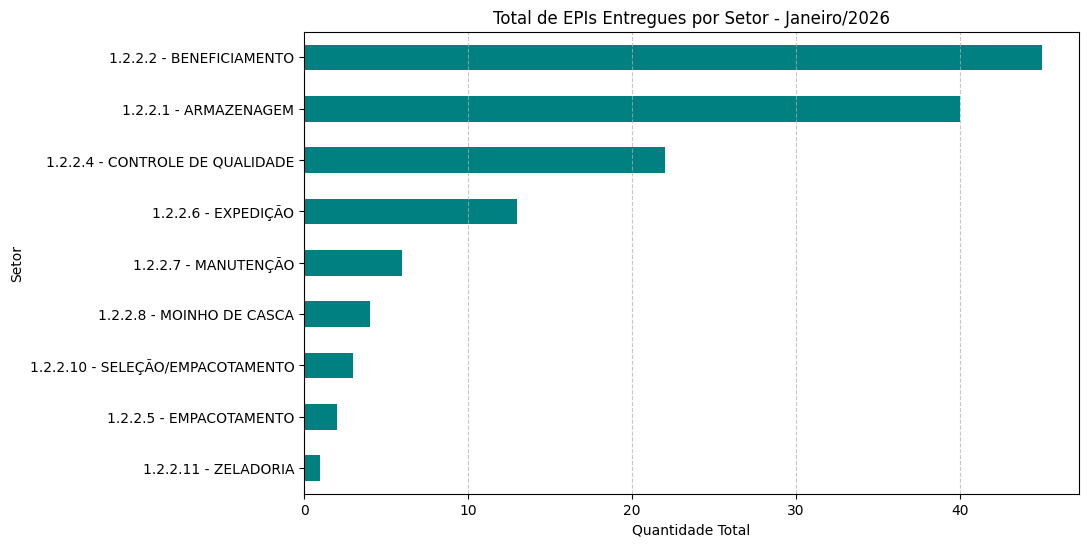

In [35]:
import matplotlib.pyplot as plt

# Gerando o gráfico de barras com a relação de entrega por setor
# Criando o agrupamento
setores_grafico = df_limpo.groupby('Setor')['Quantidade'].sum().sort_values(ascending=True)

# Configurando o gráfico
plt.figure(figsize=(10, 6))
setores_grafico.plot(kind='barh', color='teal') # barra horizontal para ler melhor os nomes

plt.title('Total de EPIs Entregues por Setor - Janeiro/2026')
plt.xlabel('Quantidade Total')
plt.ylabel('Setor')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
# Organizando os dados para gerar o gráfico de entregas por dia

dados_organizados = []
setor_atual = ""
funcionario_atual = ""

for i, linha in df_bruto.iterrows():
    if str(linha.iloc[0]).strip() == "Local:":
        setor_atual = str(linha.iloc[1])

    try:
        cadastro = float(linha.iloc[0])
        if 0 < cadastro < 100000:
            funcionario_atual = str(linha.iloc[1])
    except:
        pass


    if "5400" in str(linha.iloc[0]):
        dados_organizados.append({
            'Setor': setor_atual,
            'Funcionario': funcionario_atual,
            'EPI': linha.iloc[1],
            'Quantidade': pd.to_numeric(linha.iloc[5], errors='coerce'),
            'Data_Texto': str(linha.iloc[6]), # Capturando a data
            'Valor_Total': pd.to_numeric(linha.iloc[12], errors='coerce')
        })

df_limpo = pd.DataFrame(dados_organizados)

# Converte a coluna de texto para Data real do Python
df_limpo['Data_Real'] = pd.to_datetime(df_limpo['Data_Texto'], dayfirst=True, errors='coerce')

print("Dados atualizados com a coluna de Data!")
df_limpo.head()

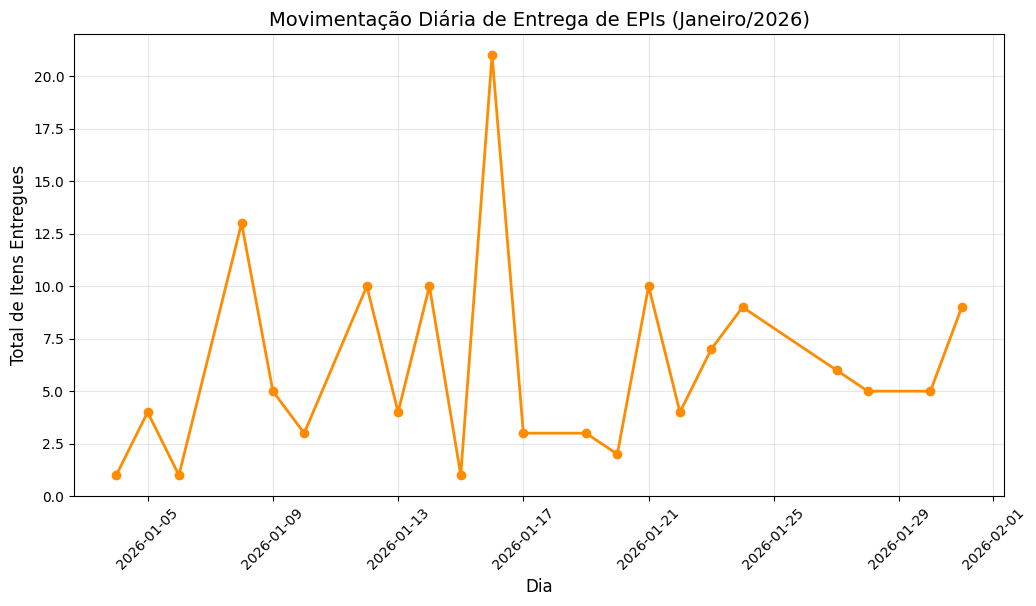

In [37]:
# Gerando o gráfico de linha com a relação de entregas por dia
# Agrupar por dia e somar as quantidades
entregas_por_dia = df_limpo.groupby('Data_Real')['Quantidade'].sum().reset_index()

# Ordenar por data para o gráfico não ficar bagunçado
entregas_por_dia = entregas_por_dia.sort_values('Data_Real')

plt.figure(figsize=(12, 6))
plt.plot(entregas_por_dia['Data_Real'], entregas_por_dia['Quantidade'],
         marker='o', linestyle='-', color='#FF8C00', linewidth=2)

plt.title('Movimentação Diária de Entrega de EPIs (Janeiro/2026)', fontsize=14)
plt.xlabel('Dia', fontsize=12)
plt.ylabel('Total de Itens Entregues', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.show()